<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/lm_generation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compares Timing, Number of Trainable Parameters and Model Performance

In [1]:
# import sys
# if 'google.colab' in sys.modules:
#     !pip install -Uqq einops

In [1]:
import sys
sys.path.append("..")

import numpy as np
import torch
import torch.autograd.profiler as profiler

from einops import rearrange

# Timing

In [2]:
def do_cuda_timing(f, inp, context=None, n_loops=100):
    f.cuda()
    inp = inp.cuda()
    if context is not None: context = context.cuda()
    with profiler.profile(record_shapes=False, use_cuda=True) as prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    if context is None: f(inp)
                    else: f(inp, context)
                    torch.cuda.synchronize()
                    
    res = round((prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
    print(f'{res}ms')
    return res

In [3]:
# Taken from fastai.callback.hook

def total_params(m):
    "Give the number of parameters of a module and if it's trainable or not"
    params = sum([p.numel() for p in m.parameters()])
    trains = [p.requires_grad for p in m.parameters()]
    return params, (False if len(trains)==0 else trains[0])

In [4]:
# OTHER PROFILER OPTIONS

# With memory
#with profiler.profile(profile_memory=True, record_shapes=True) as prof:
#     arto_encoder_layer(src)

# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [5]:
# Dict to save comparisons
comparison = {}

In [20]:
# Input 
arto_src = torch.rand(64, 128, 512).cuda()
pt_src = rearrange(arto_src, 'b l e -> l b e')

pt_context = torch.rand(192, 64, 512).cuda()
arto_context = rearrange(pt_context, 'b l e -> l b e')

# Attention

Compare the Attention from baic_transformer to TorchText's new `MultiheadAttentionContainer`

### TorchText Attention

In [7]:
from torchtext.nn.modules.multiheadattention import MultiheadAttentionContainer
from torchtext.nn.modules.multiheadattention import InProjContainer
from torchtext.nn.modules.multiheadattention import ScaledDotProduct

n_loops = 500
embed_dim, num_heads, bsz, sl = 512, 8, 64, 128

in_proj_container = InProjContainer(torch.nn.Linear(embed_dim, embed_dim),
                                        torch.nn.Linear(embed_dim, embed_dim),
                                        torch.nn.Linear(embed_dim, embed_dim))

mha = MultiheadAttentionContainer(num_heads,
                                      in_proj_container,
                                      ScaledDotProduct(),
                                      torch.nn.Linear(embed_dim, embed_dim))
mha.cuda()

# query = torch.rand((21, bsz, embed_dim))
query = key = value = torch.rand((sl, bsz, embed_dim)).cuda()

with profiler.profile(record_shapes=False, use_cuda=True) as pt_prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    attn_output, attn_weights = mha(query, key, value)
                    torch.cuda.synchronize()
                    
pt_res = round((pt_prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
print(f'{pt_res}ms')

3.36ms


In [8]:
#print(pt_prof.key_averages().table(sort_by="self_cpu_time_total"))

### Arto Attention

In [9]:
from basic_transformer import Attention

arto_src = torch.rand((bsz, sl, embed_dim)).cuda()

arto_attn = Attention(512, heads=8, causal=False, dropout=0.1)
arto_attn.cuda()

with profiler.profile(record_shapes=False, use_cuda=True) as arto_prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    arto_out = arto_attn(arto_src)
                    torch.cuda.synchronize()
                    
arto_res = round((arto_prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
print(f'{arto_res}ms')

2.77ms


In [10]:
comparison['Attention'] = {'Arto': arto_res, 'pt': pt_res}

In [28]:
total_params(mha)[0], total_params(arto_attn)[0]

(1050624, 1049088)

# Encoder 

### Encoder Layer

In [12]:
from torch.nn import TransformerEncoderLayer
from basic_transformer import TransformerEncoderBlock as artoTransformerEncoderBlock

# Pytorch
pt_encoder_layer = TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")

# ARTO
arto_encoder_layer = artoTransformerEncoderBlock(dim=512, heads=8)

Do timing

In [13]:
pt = do_cuda_timing(pt_encoder_layer, pt_src)
t = do_cuda_timing(arto_encoder_layer, arto_src)

comparison['EncoderLayer'] = {'Arto': t, 'pt': pt}

7.599ms
6.789ms


Num params

In [14]:
total_params(pt_encoder_layer)[0], total_params(arto_encoder_layer)[0]

(3152384, 3150848)

### Encoder

6-layer Encoder test

In [15]:
from torch.nn import TransformerEncoder
from basic_transformer import TransformerEncoder as artoTransformerEncoder

# Pytorch
pt_encoder_layer = TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")
pt_encoder = TransformerEncoder(pt_encoder_layer, num_layers=6)


# Arto
arto_encoder = artoTransformerEncoder(dim=512, depth=6, heads=8,
                                      causal=False, attn_dropout=0.1,
                                      ff_dropout=0.1)

In [16]:
pt = do_cuda_timing(pt_encoder, pt_src)
t = do_cuda_timing(arto_encoder, arto_src)

comparison['Encoder'] = {'Arto': t, 'pt': pt}

43.32ms
41.507ms


Num params

In [17]:
total_params(pt_encoder)[0], total_params(arto_encoder)[0]

(18914304, 18905088)

# Decoder

### DecoderLayer

In [21]:
from torch.nn import TransformerDecoderLayer
from basic_transformer import TransformerDecoderBlock as artoTransformerDecoderBlock

# Pytorch
pt_decoder_layer = TransformerDecoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")

# ARTO
arto_decoder_layer = artoTransformerDecoderBlock(dim=512, heads=8)

Do timing

In [22]:
pt = do_cuda_timing(pt_decoder_layer, pt_src, context=pt_context)

t = do_cuda_timing(arto_decoder_layer, arto_src, context=arto_context)

comparison['DecoderLayer'] = {'Arto': t, 'pt': pt}

11.641ms
10.547ms


In [23]:
total_params(pt_decoder_layer)[0], total_params(arto_decoder_layer)[0]

(4204032, 4200960)

### Decoder

6-layer Decoder test

In [24]:
from torch.nn import TransformerDecoder
from basic_transformer import TransformerDecoder as artoTransformerDecoder

# Pytorch
pt_decoder_layer = TransformerDecoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")
pt_decoder = TransformerDecoder(pt_decoder_layer, num_layers=6)

# Arto
arto_decoder = artoTransformerDecoder(dim=512, depth=6, heads=8,
                                      attn_dropout=0.1,
                                      ff_dropout=0.1)

In [25]:
pt = do_cuda_timing(pt_decoder, pt_src, context=pt_context)

t = do_cuda_timing(arto_decoder, arto_src, context=arto_context)

comparison['Decoder'] = {'Arto':t, 'pt': pt}

68.105ms
64.041ms


In [26]:
total_params(pt_decoder)[0], total_params(arto_decoder)[0]

(25224192, 25205760)

## Timing Results

In [27]:
for k in comparison.keys():
    print(k)
    for kk in comparison[k].keys():
        print(f'{kk} : {comparison[k][kk]}ms')
    print()

Attention
Arto : 2.77ms
pt : 3.36ms

EncoderLayer
Arto : 6.789ms
pt : 7.599ms

Encoder
Arto : 41.507ms
pt : 43.32ms

DecoderLayer
Arto : 10.547ms
pt : 11.641ms

Decoder
Arto : 64.041ms
pt : 68.105ms



# Training Performance

Check Perplexity performance of EncoderLM for each

In [ ]:
from basic_transformer import TransformerLM
from fastai.text.all import *
import datasets
from datasets import load_dataset
import six

### Get Data

In [6]:
from datasets.builder import FORCE_REDOWNLOAD

dataset = load_dataset('tiny_shakespeare', download_mode=FORCE_REDOWNLOAD)
train_ds = dataset['train']

def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

train_ds = train_ds.filter(lambda x: x['line'] != '')

train_ds[:10]

df = train_ds.data.to_pandas()
df.head(2)

Using custom data configuration default


Dataset tiny_shakespeare downloaded and prepared to /home/morgan/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


,line
0,First Citizen:
1,"Before we proceed any further, hear me speak."


### Tokenizer

In [7]:
class ByteTextTokenizer(Transform):
    """
        Encodes each byte to an id. For 8-bit strings only.
        Credit: https://github.com/tensorflow/tensor2tensor/blob/5f9dd2db6d7797162e53adf152310ed13e9fc711/tensor2tensor/data_generators/text_encoder.py#L176
    """
    def __init__(self, is_lm=True, add_bos=False, add_eos=False):
        self.ls_lm = is_lm
        self.add_bos, self.add_eos = add_bos, add_eos
        self.pad_token, self.eos_token, self.bos_token = '<pad>', '<eos>', '<bos>',
        self.pad_token_id, self.eos_token_id, self.bos_token_id = 0,1,2
        self.reserved_toks = [self.pad_token, self.eos_token, self.bos_token]  ## self.bos_token_id 
        self.reserved_tokens_bytes = [bytes(rtok, 'ascii') for rtok in self.reserved_toks]
        self.numres = len(self.reserved_toks)
        self.int2byte = six.int2byte

    @typedispatch
    def __call__(self, o:list, **kwargs):
        out = [c + self.numres for s in o for c in s.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
        
    @typedispatch
    def __call__(self, o:str, **kwargs):
        out = [c + self.numres for c in o.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
    
    def encodes(self,o):
        return self.__call__(o)
    
    def decodes(self, o:tuple):
        decoded_ids = ()
        for i in o:
            tmp_ls=[]
            for id_ in i:
                if 0 <= id_ < self.numres: tmp_ls.append(self.reserved_tokens_bytes[int(id_)])
                else: tmp_ls.append(self.int2byte(id_ - self.numres))
            decoded_ids = decoded_ids + (b"".join(tmp_ls).decode("utf-8", "replace"),)
        return TitledStr(decoded_ids)
    
    def decodes(self, o:list):
        decoded_ids = []
        for id_ in o:
            if 0 <= id_ < self.numres: decoded_ids.append(self.reserved_tokens_bytes[int(id_)])
            else: decoded_ids.append(self.int2byte(id_ - self.numres))
        return TitledStr(b"".join(decoded_ids).decode("utf-8", "replace"))
    
    def decodes(self, o:TensorText):
        return self.decodes(o.tolist())
    
    def decodes(self, o:LMTensorText):
        return self.decodes(o.tolist())
    
    @property
    def vocab_size(self): return 2**8 + self.numres

In [8]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

### Dataloaders

In [9]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]
    # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

vocab_sz = bte.vocab_size
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)
dls.show_batch(max_n=2)

,text,text_
0,"<bos>Had been more merciful. Come on, poor babe:<eos><bos>OXFORD:<eos><bos>The ground of your ill-will, and so remove it.<eos><bos>Now, brother of Clarence,","Had been more merciful. Come on, poor babe:<eos><bos>OXFORD:<eos><bos>The ground of your ill-will, and so remove it.<eos><bos>Now, brother of Clarence,"
1,"ves and thine<eos><bos>She is too fair, too wise, wisely too fair,<eos><bos>Hath thus stood for his country: therefore,<eos><bos>Strike the proud cedars","es and thine<eos><bos>She is too fair, too wise, wisely too fair,<eos><bos>Hath thus stood for his country: therefore,<eos><bos>Strike the proud cedars"


### Arto LM

In [10]:
from basic_transformer import TransformerEmbedding
from basic_transformer import TransformerEncoder as artoTransformerEncoder

class artoTransformerLM(nn.Module):
    """
    Basic Transformer for language modelling
    Parameters:
        * vocab_sz: int
        * dim: int - inner dimension of the model
        * depth: int (default: 6) 
        * heads: int (default: 8)
        * causal: bool (default: True) - if True does causal masking automatically
        * max_seq_len: int (default: 512)
        * tie_weights: bool - if True target embedding weights are used for computation output projection
        * pos_enc: str from {'absolute', 'fixed', 'axial'} - type of positional encoding to use
    Inputs:
        * x - input ids, shape [bs, sl]
        * mask - optional boolean mask, shape [bs, sl]
    Returns:
        * logits - target token logits, shape [bs, sl, vocab_sz]
    """
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
                 max_seq_len=512, tie_weights=True, d_ff=None,
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute'):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        self.tfmr = artoTransformerEncoder(dim, depth, heads, causal=causal, d_ff=d_ff, 
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout)
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
        
    def forward(self, x, mask=None):
        x = self.emb(x)
        x = self.tfmr(x, mask=mask)
        return self.proj(x)
    #TODO maybe refactor
    @torch.no_grad()
    def generate(self, inp,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False):
        self.to(inp.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        inp = expand_dim1(inp)
        b, t = inp.shape
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]

            logits = self(x)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if early_stopping and (sample == bte.eos_token_id).all():
                break
        # out = out[:, t:]
        return out
    # wip
    def store_attention(self):
        for m in self.modules():
            if issubclass(type(m), Attention):
                m.store_attention = True
    def get_attention_matrix(self):
        res = []
        for m in self.modules():
            if issubclass(type(m), Attention):
                attention = getattr(m, 'attention', None)
                res.append(attention)
                # reset stored attention
                m.attention = None
                m.store_attention = False
        return res

### ArtoLM Learner

In [26]:
m = artoTransformerLM(vocab_sz, 512)

learn = Learner(dls, m,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=0.0003311311302240938)

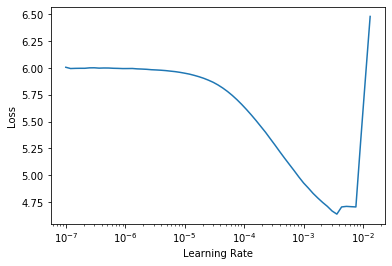

In [27]:
learn.lr_find()

In [195]:
learn.fit_one_cycle(1, 5e-4, wd=0.05)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.458413,2.371171,0.305189,10.709927,00:31


## Pytorch LM

In [11]:
from torch.nn import TransformerEncoder
from torch.nn import TransformerEncoderLayer

MASK_VAL = -1e4

class ptTransformerLM(artoTransformerLM):
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
             max_seq_len=512, tie_weights=True, d_ff=None,
             attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
             pos_enc='absolute'):
        super().__init__(vocab_sz, dim)
        self.max_seq_len = max_seq_len
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        
        ####
        self.pt_encoder_layer = TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=2048,  ## pt ENCODER LAYER
                                                  dropout=0.1, activation="gelu")
        self.tfmr = TransformerEncoder(self.pt_encoder_layer, num_layers=depth)# .cuda().float()   ## pt ENCODER
        self.causal = causal
        self.heads = heads
        ####
        
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
            
    
    # SWAP DIM POS FOR PYTORCH
    def forward(self, x, mask=None):
        x = self.emb(x)
        
        sl = x.size()[1]
        if self.causal:    
            mask = torch.ones((sl, sl), device = x.device).triu_(1).bool()
        x = rearrange(x, 'b l e -> l b e')
        x = self.tfmr(x, mask=mask)
        x = rearrange(x, 'l b e -> b l e')
        return self.proj(x)
    

In [149]:
mm = torch.ones((128, 128)).triu_(1).bool()  #[0] #.bool()[2]
mm.sum(1)

tensor([127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114,
        113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100,
         99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,
         85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,
         71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,
         57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,  46,  45,  44,
         43,  42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,  30,
         29,  28,  27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  16,
         15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,
          1,   0])

In [12]:
pt_model = ptTransformerLM(vocab_sz, 512)

In [13]:
pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

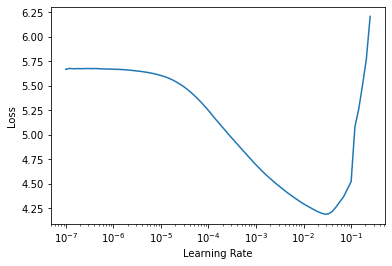

In [14]:
pt_learn.lr_find()

In [15]:
pt_learn.fit_one_cycle(1, 4e-5, wd=0.05)

epoch     train_loss  valid_loss  accuracy  perplexity  time    
0         3.294259    3.138665    0.227124  23.073048   00:31     


### Average Performance comparison

In [17]:
def model_timing(n_loops=5, model='arto', dls=None, n_epochs=1, lr=5e-4):
    acc_ls, ppl_ls =[], []
    for i in range(n_loops):
        if model == 'arto': m = artoTransformerLM(vocab_sz, 512)
        elif model == 'pt': m = ptTransformerLM(vocab_sz, 512)
        else: print('model name not correct')
        
        learn = Learner(dls, m,
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, Perplexity()]).to_native_fp16()

        learn.fit_one_cycle(n_epochs, lr, wd=0.05)
        
        acc_ls.append(learn.recorder.final_record[2])
        ppl_ls.append(learn.recorder.final_record[3])
    print(f'Avg Accuracy: {round(sum(acc_ls)/len(acc_ls),3)}, std: {np.std(acc_ls)}')
    print(f'Avg Perplexity: {round(sum(ppl_ls)/len(ppl_ls),3)}, std: {np.std(ppl_ls)}')
    print()
    return learn, acc_ls, ppl_ls

Arto

In [46]:
arto_learn, arto_acc_ls, arto_ppl_ls = model_timing(n_loops=7, model='arto', dls=dls, n_epochs=15, lr=5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.725724,2.486259,0.284096,12.016242,00:31
1,2.440484,2.371995,0.304008,10.718752,00:31
2,2.224384,2.120825,0.373249,8.338010,00:30
3,1.946482,1.827497,0.450526,6.218305,00:31
4,1.746881,1.647650,0.502347,5.194758,00:31
5,1.621592,1.539351,0.528695,4.661564,00:31
6,1.534749,1.462822,0.547596,4.318130,00:31
7,1.475206,1.400837,0.566092,4.058594,00:31
8,1.427838,1.359491,0.577330,3.894212,00:31
9,1.392439,1.318884,0.588630,3.739244,00:31


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.732715,2.485119,0.285184,12.002544,00:31
1,2.440706,2.374524,0.303858,10.745901,00:31
2,2.227057,2.128448,0.371629,8.401814,00:31
3,1.969233,1.842636,0.449854,6.313158,00:31
4,1.768464,1.673755,0.490036,5.332151,00:31
5,1.639372,1.554161,0.528358,4.731118,00:31
6,1.549466,1.466895,0.549220,4.335754,00:31
7,1.493433,1.410223,0.563847,4.096868,00:31
8,1.443335,1.367835,0.574862,3.926841,00:31
9,1.403575,1.328887,0.584647,3.776837,00:31


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.736553,2.479597,0.281501,11.936448,00:31
1,2.439210,2.372261,0.297695,10.721604,00:31
2,2.223352,2.127827,0.373918,8.396605,00:31
3,1.952720,1.830480,0.451753,6.236878,00:31
4,1.746006,1.651795,0.501371,5.216332,00:31
5,1.620010,1.531777,0.531510,4.626390,00:31
6,1.540389,1.456162,0.552113,4.289464,00:32
7,1.475821,1.397687,0.568161,4.045832,00:31
8,1.430377,1.357896,0.574419,3.888003,00:31
9,1.394468,1.319234,0.589009,3.740557,00:31


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.733024,2.481131,0.283699,11.954779,00:31
1,2.441283,2.375537,0.303544,10.756784,00:30
2,2.231082,2.128985,0.368842,8.406327,00:31
3,1.953435,1.835791,0.451389,6.270095,00:31
4,1.746979,1.643133,0.504445,5.171344,00:31
5,1.616691,1.539211,0.531368,4.660913,00:31
6,1.540883,1.465675,0.547532,4.330464,00:31
7,1.481224,1.401942,0.567564,4.063084,00:32
8,1.434649,1.356890,0.577672,3.884094,00:31
9,1.392331,1.320515,0.586885,3.745350,00:31


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.732126,2.480909,0.286135,11.952120,00:31
1,2.442925,2.388596,0.294347,10.898186,00:31
2,2.232930,2.133023,0.371808,8.440342,00:31
3,1.954245,1.845306,0.451415,6.330035,00:31
4,1.742547,1.640368,0.502409,5.157066,00:31
5,1.614605,1.525799,0.534493,4.598816,00:31
6,1.532481,1.459330,0.552514,4.303076,00:31
7,1.470850,1.401550,0.568138,4.061491,00:31
8,1.426342,1.356013,0.578061,3.880690,00:32
9,1.389296,1.319251,0.588351,3.740618,00:31


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.740378,2.487982,0.280259,12.036962,00:31
1,2.441256,2.384029,0.298859,10.848520,00:31
2,2.221972,2.130103,0.371260,8.415736,00:32
3,1.967853,1.855174,0.446297,6.392813,00:31
4,1.761382,1.660730,0.496392,5.263149,00:31
5,1.629837,1.553188,0.526404,4.726513,00:31
6,1.543629,1.467496,0.549195,4.338357,00:32
7,1.481548,1.405139,0.565928,4.076095,00:31
8,1.437749,1.360553,0.577482,3.898350,00:31
9,1.394468,1.324288,0.585478,3.759506,00:31


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.734092,2.478810,0.283009,11.927064,00:31
1,2.438531,2.378391,0.297837,10.787532,00:31
2,2.219206,2.134555,0.371849,8.453287,00:31
3,1.953437,1.842983,0.446833,6.315350,00:31
4,1.750917,1.648087,0.500334,5.197026,00:31
5,1.624551,1.540707,0.530341,4.667892,00:31
6,1.543888,1.462809,0.549951,4.318074,00:31
7,1.489819,1.409706,0.564856,4.094750,00:31
8,1.432358,1.362052,0.574673,3.904195,00:31
9,1.396083,1.325199,0.586341,3.762935,00:31


Avg Accuracy: 0.606, std: 0.000970432230916555
Avg Perplexity: 3.494, std: 0.011039156893668741



Pytorch

In [18]:
pt_learn, pt_acc_ls, pt_ppl_ls = model_timing(n_loops=7, model='pt', dls=dls, n_epochs=15, lr=5e-4)

epoch     train_loss  valid_loss  accuracy  perplexity  time    
0         2.937238    2.551770    0.283704  12.829795   00:31     
1         2.341835    2.211590    0.355974  9.130218    00:30     
2         1.972779    1.839023    0.451645  6.290387    00:31     
3         1.718368    1.611390    0.509064  5.009770    00:31     
4         1.579673    1.487297    0.543451  4.425117    00:31     
5         1.495771    1.413877    0.561926  4.111867    00:31     
6         1.437492    1.360043    0.577840  3.896359    00:31     
7         1.390486    1.314164    0.589124  3.721638    00:31     
8         1.354231    1.277807    0.598650  3.588760    00:31     
9         1.319744    1.245034    0.607840  3.473053    00:31     
10        1.285656    1.222012    0.612911  3.394011    00:31     
11        1.265460    1.198145    0.621247  3.313962    00:30     
12        1.242040    1.184194    0.624083  3.268051    00:31     
13        1.230900    1.178317    0.626560  3.248903    00:31   

Performance Results

ARTO:

- Avg Accuracy: 0.606, std: 0.0009704
- Avg Perplexity: 3.494, std: 0.01103

PT:

- Avg Accuracy: 0.626, std: 0.0008662468796634467
- Avg Perplexity: 3.255, std: 0.009614346466018758

## Generation

In [29]:
# credit https://github.com/huggingface/transformers/blob/a0c62d249303a68f5336e3f9a96ecf9241d7abbe/src/transformers/generation_logits_process.py
def top_p_filter(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    # if min_tokens_to_keep > 1:
    #         # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
    #         sorted_indices_to_remove[..., : min_tokens_to_keep - 1] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    scores[indices_to_remove] = float('-inf')
    return scores

def top_k_filter(logits, top_k=20):
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    logits[indices_to_remove] = float('-inf')
    return logits

_sampler = {
    'top_k':top_k_filter,
    'top_p':top_p_filter,
    'gready':lambda x: x.argmax(-1)
}

@torch.no_grad()
def generate(model,
             inp,
             max_len=50,
             temperature=1.,
             method = 'top_k',
             top_k = 20,
             top_p = 0.9,
             early_stopping=False):
    model.eval()
    thresh = top_k if method=='top_k' else top_p
    sampler = _sampler[method]

    if len(inp.shape) == 1:
        inp = inp[None, :]
    b, t = inp.shape
    out = inp
    
    for _ in range(max_len):
        x = out[:, -model.max_seq_len:]

        logits = model(x)[:, -1, :]
        if method == 'greedy':
            sample = sampler(logits)
        else:
            filtered_logits = sampler(logits)
            probs = F.softmax(filtered_logits / temperature, dim=-1)
            sample = torch.multinomial(probs, 1)

        out = torch.cat((out, sample), dim=-1)

        if early_stopping and (sample == bte.eos_token_id).all():
            break
    # out = out[:, t:]
    return out

In [31]:
# out = generate(arto_learn.model, tensor([[2]]).cuda(),
#                max_len = 100,
#                early_stopping=False,
#                temperature=1.)

# [bte.decode(x.cpu().tolist()) for x in out]

In [32]:
# out = generate(pt_learn.model, tensor([[2]]).cuda(),
#                max_len = 100,
#                early_stopping=False,
#                temperature=1.)

# [bte.decode(x.cpu().tolist()) for x in out]